# Multi-Model TestBook

## Imports

In [33]:
# Imports
import os
# MUST be set before importing any PyTorch/CUDA modules
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import torch
# Configure PyTorch for full determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import seaborn as sns
import pandas as pd
from torchvision import datasets, transforms, models
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchmetrics import Accuracy, F1Score, Precision, Recall
from torchvision.transforms import v2
from tqdm import tqdm
import time
import re

## ViT Branch

### Dataset

In [34]:
# Enhanced Data Preparation with Stratified Splitting
class FireDataset(pl.LightningDataModule):
    def __init__(self, data_dir="dataset/RGB", batch_size=32, num_workers=4, train_augmented_multiplicity=4):
        """
        Custom PyTorch Lightning DataModule for fire detection dataset.

        Args:
            data_dir: Root directory containing image dataset
            batch_size: Number of samples per batch
            num_workers: Parallel threads for data loading
            train_augmented_multiplicity: Multiplier for training data augmentation (each sample seen N times with different transforms)
        """
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_augmented_multiplicity = train_augmented_multiplicity
        self.classes = None  # Will store class names after dataset setup

        # Initialize transforms as None (defined later in setup to avoid early torchvision import)
        self.transform = None  # Standard validation/test transform
        self.augment = None   # Augmentation transform for training

    def setup(self, stage=None):
        """
        Prepares datasets and performs stratified splitting.
        Called automatically by PyTorch Lightning on each GPU.
        """
        # Standard transforms for validation/testing (no augmentation)
        self.transform = transforms.Compose([
            transforms.Resize(256),          # Resize shorter side to 256
            transforms.CenterCrop(224),      # Center crop to 224x224
            transforms.ToTensor(),           # Convert to tensor
            transforms.Normalize(            # ImageNet normalization
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

        # Augmentation transforms for training data
        self.augment = transforms.Compose([
            transforms.Resize(256),                 # Resize shorter side
            transforms.RandomResizedCrop(224),       # Random crop with scaling
            transforms.RandomHorizontalFlip(),       # Random left-right flip
            transforms.RandomVerticalFlip(),         # Random top-bottom flip
            transforms.RandomRotation(15),          # Random rotation ±15 degrees
            transforms.ColorJitter(                 # Random color adjustments
                brightness=0.2,
                contrast=0.2,
                saturation=0.2
            ),
            transforms.RandomAffine(                # Random translation
                degrees=0,
                translate=(0.1, 0.1)
            ),
            transforms.ToTensor(),                  # Convert to tensor
            transforms.Normalize(                   # ImageNet normalization
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

        # Load base dataset without transforms to get original structure
        base_dataset = datasets.ImageFolder(root=self.data_dir, transform=None)
        self.classes = base_dataset.classes  # Store class names
        targets = [s[1] for s in base_dataset.samples]  # Extract class labels

        # Create stratified train/val/test splits (80/10/10)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        # Generate indices: 80% train, 20% temporary test
        train_idx, test_idx = next(skf.split(np.zeros(len(targets)), targets))
        # Split temporary test into validation (10%) and final test (10%)
        val_idx, test_idx = train_idx[:int(0.8*len(train_idx))], train_idx[int(0.8*len(train_idx)):]

        # Create specialized datasets with transforms
        # Training set with augmentations and multiplicity
        self.train_dataset = self._create_dataset_with_transform(
            base_dataset,
            train_idx,
            self.augment,
            num_augmented=self.train_augmented_multiplicity
        )
        # Validation set with standard transform
        self.val_dataset = self._create_dataset_with_transform(
            base_dataset,
            val_idx,
            self.transform
        )
        # Test set with standard transform
        self.test_dataset = self._create_dataset_with_transform(
            base_dataset,
            test_idx,
            self.transform
        )

        # Store original targets for class balancing calculations
        self.base_targets = targets

    def _create_dataset_with_transform(self, base_dataset, indices, transform, num_augmented=1):
        """
        Creates custom dataset with transformation pipeline.

        Args:
            base_dataset: Original ImageFolder dataset
            indices: Selected sample indices
            transform: Transformation pipeline to apply
            num_augmented: Augmentation multiplier (N variations per sample)

        Returns:
            Custom dataset that applies transforms and augmentation multiplicity
        """
        class DatasetWithTransform(torch.utils.data.Dataset):
            def __init__(self, base, indices, transform, num_augmented):
                self.base = base
                self.indices = indices        # Selected subset indices
                self.transform = transform    # Transformation pipeline
                self.num_augmented = num_augmented  # Augmentation multiplier

            def __len__(self):
                # Total size = original samples × augmentation multiplier
                return len(self.indices) * self.num_augmented

            def __getitem__(self, idx):
                # Calculate original dataset index
                base_idx = self.indices[idx // self.num_augmented]
                # Retrieve original image and label
                img, label = self.base[base_idx]

                # Apply transformation (different random augmentations for each call)
                if self.transform:
                    img = self.transform(img)
                return img, label

        return DatasetWithTransform(base_dataset, indices, transform, num_augmented)

    def train_dataloader(self):
        """Returns training dataloader with shuffling"""
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,            # Important for training
            num_workers=self.num_workers,
            pin_memory=True          # Faster data transfer to GPU
        )

    def val_dataloader(self):
        """Returns validation dataloader without shuffling"""
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,           # No need to shuffle validation
            num_workers=self.num_workers,
            pin_memory=True
        )

    def test_dataloader(self):
        """Returns test dataloader without shuffling"""
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,          # Maintain original order for evaluation
            num_workers=self.num_workers,
            pin_memory=True
        )

### ViT Model

In [35]:
# Vision Transformer (ViT) Feature Extractor with Classification Head
class FireFeatureExtractorViT(pl.LightningModule):
    def __init__(self, config=None):
        """
        Custom Vision Transformer model for fire detection with feature extraction capability.

        Args:
            config: Configuration dictionary with hyperparameters. Defaults to empty dict.
        """
        super().__init__()
        self.config = config or {}
        self.save_hyperparameters(config)  # Save config for checkpointing

        # Initialize with pretrained weights if specified, otherwise random initialization
        weights = ViT_B_16_Weights.IMAGENET1K_V1 if self.config.get("pretrained", True) else None
        self.vit = vit_b_16(weights=weights)

        # Freeze backbone parameters if requested (transfer learning)
        if self.config.get("freeze_backbone", True):
            for param in self.vit.parameters():
                param.requires_grad = False

        # Replace classification head with identity to output raw features (768-dim)
        self.vit.heads = nn.Identity()

        # Custom classification head for binary fire detection
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),  # Feature compression layer
            nn.ReLU(),            # Activation for non-linearity
            nn.BatchNorm1d(256),  # Normalization for stability
            nn.Dropout(self.config.get("dropout_rate", 0.5)),  # Regularization
            nn.Linear(256, 1)     # Binary classification output (fire/no-fire)
        )

        # Loss function with class weighting to handle imbalanced datasets
        self.criterion = nn.BCEWithLogitsLoss(
            pos_weight=torch.tensor(self.config.get("pos_weight", 1.0))
        )

        # Accuracy metrics for different phases
        self.train_acc = Accuracy(task='binary')
        self.val_acc = Accuracy(task='binary')
        self.test_acc = Accuracy(task='binary')

    def forward(self, x):
        """Feature extraction pass - returns 768-dimensional embeddings"""
        return self.vit(x)

    def classify(self, x):
        """Full classification pass (features + classifier head)"""
        features = self.vit(x)  # Extract visual features
        return self.classifier(features).squeeze(1)  # Remove extra dimension

    def configure_optimizers(self):
        """Configure optimizer and learning rate scheduler"""
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.config.get("lr", 1e-4),                # Default learning rate
            weight_decay=self.config.get("weight_decay", 1e-4)  # L2 regularization
        )

        # Learning rate scheduler that reduces when validation accuracy plateaus
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='max',     # Monitor validation accuracy (maximize)
            factor=0.5,     # Reduce LR by half when triggered
            patience=3,     # Wait 3 epochs without improvement
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_acc",  # Watch validation accuracy
                "frequency": 1         # Check every epoch
            }
        }

    def training_step(self, batch, batch_idx):
        """Single training step with loss calculation and metrics logging"""
        images, labels = batch
        labels = labels.float()  # Convert to float for BCE loss

        # Forward pass through classifier
        outputs = self.classify(images)
        loss = self.criterion(outputs, labels)

        # Convert logits to binary predictions (threshold=0.5)
        preds = torch.sigmoid(outputs) > 0.5
        self.train_acc(preds, labels)  # Update accuracy metric

        # Log training metrics (step-level loss, epoch-level accuracy)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", self.train_acc, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        """Single validation step with metrics calculation"""
        images, labels = batch
        labels = labels.float()

        # Forward pass
        outputs = self.classify(images)
        loss = self.criterion(outputs, labels)

        # Calculate accuracy
        preds = torch.sigmoid(outputs) > 0.5
        self.val_acc(preds, labels)

        # Log validation metrics (epoch-level only)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", self.val_acc, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        """Single test step for final evaluation"""
        images, labels = batch
        labels = labels.float()

        # Forward pass
        outputs = self.classify(images)
        loss = self.criterion(outputs, labels)

        # Calculate accuracy
        preds = torch.sigmoid(outputs) > 0.5
        self.test_acc(preds, labels)

        # Log test metrics
        self.log("test_loss", loss, on_epoch=True)
        self.log("test_acc", self.test_acc, on_epoch=True)

        return loss

### Training

In [36]:
# Training Function
def train_feature_extractor(num_epochs):
    """
    Trains the fire feature extractor model end-to-end.

    Args:
        num_epochs: Number of training epochs

    Returns:
        model: Trained feature extractor model
        trainer: PyTorch Lightning trainer object
        data: Data module used for training
    """
    # Initialize data module with default batch size
    data = FireDataset(batch_size=32)
    data.setup()  # Prepare datasets and transformations

    # Calculate class imbalance weight for positive samples
    # Example: [non-fire_count, fire_count] - replace with actual counts
    class_counts = [1000, 200]  # Example: [negative_class, positive_class]
    pos_weight = class_counts[0] / class_counts[1]  # weight = negative_count / positive_count

    # Model configuration parameters
    config = {
        "lr": 1e-4,               # Learning rate
        "weight_decay": 1e-4,      # L2 regularization strength
        "freeze_backbone": True,   # Freeze ViT weights during training
        "pretrained": True,        # Use pretrained ViT weights
        "dropout_rate": 0.5,       # Dropout probability in classifier
        "pos_weight": pos_weight   # Class imbalance compensation
    }

    # Initialize model with configuration
    model = FireFeatureExtractorViT(config)

    # Model checkpoint callback - saves best model based on validation accuracy
    checkpoint = ModelCheckpoint(
        monitor="val_acc",         # Metric to monitor
        mode="max",                # Maximize validation accuracy
        save_top_k=1,              # Save only the best model
        filename="best_feature_extractor"  # Checkpoint filename
    )

    # Create PyTorch Lightning trainer
    trainer = pl.Trainer(
        max_epochs=num_epochs,    # Training duration
        callbacks=[checkpoint],    # Attach checkpoint callback
        accelerator="auto",        # Automatically select hardware (GPU/CPU)
        devices=1,                # Use single device
        log_every_n_steps=10,     # Log metrics every 10 batches
    )

    # Train the model
    trainer.fit(model, data)

    # Evaluate on test set after training
    test_result = trainer.test(model, dataloaders=data.test_dataloader())
    print(f"Test Accuracy: {test_result[0]['test_acc']:.4f}")

    return model, trainer, data

# Save Feature Extractor
def save_feature_extractor(trainer, path="feature_extractor.pth"):
    """
    Saves the trained feature extractor as a Lightning checkpoint.

    Preserves model weights, hyperparameters, and optimizer state.

    Args:
        trainer: Trainer instance containing the model
        path: Output file path for checkpoint
    """
    # Save entire model state including metadata and optimizer
    trainer.save_checkpoint(path)
    print(f"Full Lightning checkpoint saved to {path}")

# Feature Extraction Function
def extract_features(model, dataloader):
    """
    Extracts feature vectors from images using the trained model.

    Args:
        model: Trained feature extractor model
        dataloader: DataLoader providing image batches

    Returns:
        features: 2D array of extracted features [n_samples, 768]
        labels: 1D array of corresponding labels
    """
    model.eval()  # Set model to evaluation mode
    features = []  # Storage for feature vectors
    labels = []    # Storage for corresponding labels

    with torch.no_grad():  # Disable gradient calculation
        for images, batch_labels in dataloader:
            # Move images to same device as model (GPU/CPU)
            images = images.to(model.device)

            # Extract features (768-dimensional vectors)
            batch_features = model(images)

            # Store results (move to CPU for numpy conversion)
            features.append(batch_features.cpu().numpy())
            labels.append(batch_labels.numpy())

    # Combine all batches into single arrays
    return np.concatenate(features), np.concatenate(labels)

In [37]:
# --- TRAINING PIPELINE EXECUTION ---
# Clear GPU memory cache to avoid out-of-memory errors
torch.cuda.empty_cache()

# Start performance timer
start = time.time()

# Step 1: Train the feature extractor model
print("Training feature extractor...")
trained_model, trainer, data = train_feature_extractor(num_epochs=50)

# Step 2: Save the trained model for future use
save_feature_extractor(trainer, "Saved_Features/ViT_fire_feature_extractor.pth")

# Step 3: Load the feature extractor (without classifier head)
print("\nLoading feature extractor for inference...")
# Initialize model with default configuration
feature_extractor = FireFeatureExtractorViT()
# Load weights while ignoring classifier parameters (strict=False)
feature_extractor.load_state_dict(
    torch.load("Saved_Features/ViT_fire_feature_extractor.pth"),
    strict=False  # Required since we're discarding the classifier
)
feature_extractor.eval()  # Set to evaluation mode

# Step 4: Extract feature vectors from training data
print("\nExtracting features from training dataset...")
train_features, train_labels = extract_features(
    feature_extractor,
    data.train_dataloader()
)
print(f"Extracted {len(train_features)} feature vectors (768-dim each)")

# Step 5: Demonstrate feature usage for downstream models
print("\nFeatures ready for transfer learning or multi-model systems:")
print(f"Feature vector shape: {train_features[0].shape}")  # Should be (768,)
print(f"Sample feature (first 10 values): {train_features[0][:10]}...")

# Calculate and display execution time
time_taken = time.time() - start
print(f"\nTotal Execution Time: {time_taken:.2f} seconds ({time_taken / 60:.2f} minutes)")

Training feature extractor...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | vit        | VisionTransformer | 85.8 M | train
1 | classifier | Sequential        | 197 K  | train
2 | criterion  | BCEWithLogitsLoss | 0      | train
3 | train_acc  | BinaryAccuracy    | 0      | train
4 | val_acc    | BinaryAccuracy    | 0      | train
5 | test_acc   | BinaryAccuracy    | 0      | train
---------------------------------------------------------
197 K     Trainable params
85.8 M    Non-trainable params
86.0 M    Total params
343.985   Total estimated model params size (MB)
161       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            1.0            │
│         test_loss         │   0.005266088526695967    │
└───────────────────────────┴───────────────────────────┘

Test Accuracy: 1.0000
Full Lightning checkpoint saved to Saved_Features/ViT_fire_feature_extractor.pth

Loading feature extractor for inference...

Extracting features from training dataset...
Extracted 2064 feature vectors (768-dim each)

Features ready for transfer learning or multi-model systems:
Feature vector shape: (768,)
Sample feature (first 10 values): [-0.64571846  0.32698774 -0.3455914   0.02660201  0.18178685  0.8263693
 -0.7369985   0.02089056  0.43907887  1.0128295 ]...

Total Execution Time: 7369.29 seconds (122.82 minutes)


## CNN Branch

### Dataset

In [49]:
# Custom Dataset Class for Thermal Images
class CustomImageDataset(Dataset):
    """
    PyTorch Dataset for loading thermal images with associated labels.

    Args:
        image_paths: List of full paths to image files
        labels: List of corresponding labels (0 for non-fire, 1 for fire)
        transform: Composition of image transformations to apply
    """
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform  # Image preprocessing pipeline

    def __len__(self):
        """Returns total number of samples in dataset"""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """Loads and transforms image at index, returns (image, label)"""
        img_path = self.image_paths[idx]
        image = Image.open(img_path)  # Load image using PIL
        label = self.labels[idx]       # Get corresponding label

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, label

# --- IMAGE TRANSFORMATION PIPELINES ---
# Training augmentation pipeline (applied to training set only)
augment_transform = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),  # Random crop and resize
    v2.RandomHorizontalFlip(p=0.5),                         # Random left-right flip
    v2.GaussianBlur(kernel_size=3, sigma=(0.5, 2.0)),        # Add blur for robustness
    v2.ToImage(),                                           # Convert to tensor
    v2.ToDtype(torch.float32, scale=True),                  # Normalize to [0,1]
    v2.Grayscale(num_output_channels=1),                    # Convert to single channel
    v2.Normalize(mean=[0.5], std=[0.5]),                    # Scale to [-1,1] range
])

# Testing/validation pipeline (minimal transformation)
test_transform = v2.Compose([
    v2.Resize(size=(224, 224), antialias=True),  # Fixed size resize
    v2.ToImage(),                                # Convert to tensor
    v2.ToDtype(torch.float32, scale=True),       # Normalize to [0,1]
    v2.Grayscale(num_output_channels=1),         # Convert to single channel
    v2.Normalize(mean=[0.5], std=[0.5]),         # Scale to [-1,1] range
])

# --- DATASET LOADING ---
# Define paths to thermal image directories
fire_dir = 'dataset/thermal/fire'      # Directory containing fire images
non_fire_dir = 'dataset/thermal/no_fire'  # Directory containing non-fire images

image_paths = []  # Will store full paths to all images
labels = []       # Will store corresponding labels (1=fire, 0=non-fire)

# Load fire images (label=1)
if os.path.isdir(fire_dir):
    for filename in os.listdir(fire_dir):
        # Process only image files with common extensions
        if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            image_paths.append(os.path.join(fire_dir, filename))
            labels.append(1)  # Fire label

# Load non-fire images (label=0)
if os.path.isdir(non_fire_dir):
    for filename in os.listdir(non_fire_dir):
        if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            image_paths.append(os.path.join(non_fire_dir, filename))
            labels.append(0)  # Non-fire label

# Print dataset statistics
print(f"Number of fire images found: {labels.count(1)}")
print(f"Number of non-fire images found: {labels.count(0)}")
print(f"Total number of images found: {len(image_paths)}")

# --- DATASET SPLITTING ---
if len(image_paths) > 0:
    # Initial split: 80% training+validation, 20% testing (stratified by class)
    train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(
        image_paths, labels,
        test_size=0.2,
        random_state=42,
        stratify=labels  # Maintain class distribution
    )

    # Secondary split: 75% training, 25% validation (of the 80% training set)
    train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(
        train_image_paths, train_labels,
        test_size=0.25,  # 0.25 * 0.8 = 20% of total data
        random_state=42,
        stratify=train_labels  # Maintain class distribution
    )

    # Print split sizes
    print(f"\nSplit Sizes:")
    print(f" - Training set: {len(train_image_paths)} images")
    print(f" - Validation set: {len(val_image_paths)} images")
    print(f" - Test set: {len(test_image_paths)} images")

    # Create dataset instances with appropriate transforms
    train_dataset = CustomImageDataset(
        train_image_paths, train_labels,
        transform=augment_transform  # Apply augmentations
    )
    val_dataset = CustomImageDataset(
        val_image_paths, val_labels,
        transform=test_transform    # Minimal transformation
    )
    test_dataset = CustomImageDataset(
        test_image_paths, test_labels,
        transform=test_transform    # Minimal transformation
    )

    # Verify dataset sizes
    print("\nDataset Sizes:")
    print(f" - Training dataset: {len(train_dataset)} samples")
    print(f" - Validation dataset: {len(val_dataset)} samples")
    print(f" - Test dataset: {len(test_dataset)} samples")

    # --- DATALOADER CREATION ---
    batch_size = 16  # Number of samples per batch

    # Training dataloader with shuffling
    train_dataloaderCNN = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True  # Important for training
    )

    # Validation dataloader without shuffling
    val_dataloaderCNN = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False  # Maintain order for consistent evaluation
    )

    # Test dataloader without shuffling
    test_dataloaderCNN = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False  # Maintain order for final evaluation
    )

    # Print dataloader statistics
    print("\nDataloader Statistics:")
    print(f" - Training batches: {len(train_dataloaderCNN)}")
    print(f" - Validation batches: {len(val_dataloaderCNN)}")
    print(f" - Test batches: {len(test_dataloaderCNN)}")
else:
    print("Error: No images found. Check directory paths and file extensions.")

Number of fire images found: 417
Number of non-fire images found: 116
Total number of images found: 533

Split Sizes:
 - Training set: 319 images
 - Validation set: 107 images
 - Test set: 107 images

Dataset Sizes:
 - Training dataset: 319 samples
 - Validation dataset: 107 samples
 - Test dataset: 107 samples

Dataloader Statistics:
 - Training batches: 20
 - Validation batches: 7
 - Test batches: 7


### CNN Model

In [50]:
class FireFeatureExtractorCNN(nn.Module):
    """
    Custom CNN feature extractor based on MobileNetV2 for fire detection in thermal images.

    Modifies the first layer to accept single-channel (grayscale) input while preserving
    pretrained knowledge through weight averaging. Includes feature refinement layers
    and an optional classification head.
    """
    def __init__(self, feature_dim=1280):
        """
        Initialize the feature extractor.

        Args:
            feature_dim: Dimensionality of MobileNetV2's output features (default: 1280)
        """
        super(FireFeatureExtractorCNN, self).__init__()
        # Load pretrained MobileNetV2 (ImageNet weights)
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        # --- INPUT CHANNEL ADAPTATION ---
        # Modify first convolution layer to accept 1-channel (grayscale) input
        original_first_conv = self.base_model.features[0][0]
        self.base_model.features[0][0] = nn.Conv2d(
            1,  # Single channel input (thermal images)
            original_first_conv.out_channels,
            kernel_size=original_first_conv.kernel_size,
            stride=original_first_conv.stride,
            padding=original_first_conv.padding,
            bias=False  # Match original MobileNet configuration
        )

        # Initialize with averaged RGB weights (preserve pretrained knowledge)
        with torch.no_grad():
            # Average weights across RGB channels: [out, 3, k, k] -> [out, 1, k, k]
            new_weight = original_first_conv.weight.mean(dim=1, keepdim=True)
            self.base_model.features[0][0].weight.copy_(new_weight)

        # --- FEATURE EXTRACTION LAYERS ---
        # Use MobileNetV2's convolutional feature blocks
        self.features = self.base_model.features

        # Feature processing: Global pooling + flattening
        self.feature_processor = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Reduce spatial dimensions to 1x1
            nn.Flatten()                   # Convert to 1D feature vector
        )

        # --- FEATURE REFINEMENT ---
        # Additional layers to process extracted features
        self.feature_refiner = nn.Sequential(
            nn.Linear(feature_dim, 512),  # Compress features
            nn.ReLU(inplace=True),         # Non-linear activation
            nn.Dropout(0.3)                # Regularization
        )

        # --- CLASSIFICATION HEAD ---
        # Final layer for binary classification (fire/no-fire)
        self.classifier = nn.Linear(512, 1)  # Output: single logit

    def forward(self, x, return_features=False):
        """
        Forward pass with option to return intermediate features.

        Args:
            x: Input tensor (batch_size, 1, H, W)
            return_features: Whether to return refined features

        Returns:
            logits: Classification outputs when return_features=False
            (logits, features): Tuple when return_features=True
        """
        # Feature extraction through MobileNetV2 backbone
        x = self.features(x)

        # Process features: pooling + flattening
        x = self.feature_processor(x)

        # Refine features through additional layers
        features = self.feature_refiner(x)

        # Classification output (used during training)
        logits = self.classifier(features)

        # Return features if requested (for feature extraction use)
        if return_features:
            return logits, features
        return logits

### Training

In [56]:
# --- MODEL TRAINING AND EVALUATION FUNCTIONS ---
def train_model(model, train_dataloader, val_dataloader, num_epochs=10, lr=0.001):
    """
    Trains a model end-to-end with validation monitoring and best model saving.

    Args:
        model: Model to train
        train_dataloader: Training data loader
        val_dataloader: Validation data loader
        num_epochs: Number of training epochs
        lr: Learning rate

    Returns:
        model: Trained model with best weights loaded
    """
    # Set device (GPU if available, else CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    print(f"Training on: {device}")

    # Loss and optimizer configuration
    criterion = nn.BCEWithLogitsLoss()  # Binary cross entropy with logits
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Adam optimizer

    # Track training history
    train_losses = []  # Training loss per epoch
    val_losses = []    # Validation loss per epoch
    val_accuracies = []  # Validation accuracy per epoch

    # Best model tracking
    best_val_acc = 0.0
    best_model_state = None  # Store best model weights

    # Epoch loop
    for epoch in range(num_epochs):
        # --- TRAINING PHASE ---
        model.train()  # Set model to training mode
        running_loss = 0.0  # Accumulate loss
        # Progress bar with dynamic updates
        progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

        # Batch iteration
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device).float()

            # Reset gradients
            optimizer.zero_grad()

            # Forward pass and loss calculation
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)  # Remove extra dimensions

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            # Update statistics
            running_loss += loss.item() * images.size(0)  # Weight by batch size
            progress_bar.set_postfix({'loss': loss.item()})  # Update progress bar

        # Calculate epoch training loss
        epoch_loss = running_loss / len(train_dataloader.dataset)
        train_losses.append(epoch_loss)

        # --- VALIDATION PHASE ---
        val_loss, val_acc = validate_model(model, val_dataloader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Save best model checkpoint
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()  # Deep copy of weights
            print(f"New best model with val_acc: {val_acc:.4f}")

        # Epoch summary
        print(f'Epoch {epoch+1}/{num_epochs} - '
              f'Train Loss: {epoch_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Acc: {val_acc:.4f}')

    # Visualize training history
    plot_training_history(train_losses, val_losses, val_accuracies)

    # Save best weights to disk
    torch.save(best_model_state, 'Saved_Features/CNN_best_model_weights.pth')
    print("Saved best model weights to 'Saved_Features/CNN_best_model_weights.pth'")

    # Load best weights into model
    model.load_state_dict(best_model_state)

    return model

def validate_model(model, val_dataloader, criterion, device):
    """
    Evaluates model performance on validation set.

    Args:
        model: Model to evaluate
        val_dataloader: Validation data loader
        criterion: Loss function
        device: Computation device

    Returns:
        val_loss: Average validation loss
        val_acc: Validation accuracy
    """
    model.eval()  # Set to evaluation mode
    running_loss = 0.0
    correct = 0  # Correct prediction count
    total = 0    # Total samples

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device).float()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)

            # Accumulate loss
            running_loss += loss.item() * images.size(0)

            # Calculate accuracy
            preds = torch.sigmoid(outputs) > 0.5  # Convert logits to binary predictions
            correct += (preds.squeeze() == labels).sum().item()
            total += labels.size(0)

    # Calculate metrics
    val_loss = running_loss / len(val_dataloader.dataset)
    val_acc = correct / total

    return val_loss, val_acc

def test_model(model, test_dataloader, device):
    """
    Evaluates model on test set and extracts features.

    Args:
        model: Trained model (should support return_features)
        test_dataloader: Test data loader
        device: Computation device

    Returns:
        test_acc: Test accuracy
        all_features: Extracted features from test set
        all_labels: Corresponding labels
    """
    model.eval()
    correct = 0
    total = 0
    all_features = []  # Feature storage
    all_labels = []    # Label storage

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device).float()

            # Forward pass to get features and logits
            outputs, features = model(images, return_features=True)

            # Store features and labels for later analysis
            all_features.append(features.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

            # Calculate accuracy
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds.squeeze() == labels).sum().item()
            total += labels.size(0)

    # Final test accuracy
    test_acc = correct / total
    print(f'Test Accuracy: {test_acc:.4f}')

    # Combine all batches
    all_features = np.concatenate(all_features)
    all_labels = np.concatenate(all_labels)

    return test_acc, all_features, all_labels

def plot_training_history(train_losses, val_losses, val_accuracies):
    """
    Plots training history and saves to file.

    Args:
        train_losses: List of training losses per epoch
        val_losses: List of validation losses per epoch
        val_accuracies: List of validation accuracies per epoch
    """
    plt.figure(figsize=(12, 4))

    # Loss plot (left)
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Accuracy plot (right)
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Val Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Ensure accuracy range is visible
    plt.legend()
    plt.title('Validation Accuracy')

    # Save and close plot
    plt.tight_layout()
    plt.savefig('Figures/CNN_training_history.png')
    plt.close()
    print("Saved training history plot to 'CNN_training_history.png'")

def save_feature_extractor_cnn(model, path="Saved_Features/CNN_feature_extractor.pth"):
    """
    Saves CNN feature extractor weights without classification head.

    Args:
        model: Trained model with feature extraction layers
        path: Output file path
    """
    # Create state dictionary excluding classifier layers
    state_dict = model.state_dict()
    # Identify classifier parameters to remove
    keys_to_remove = [k for k in state_dict.keys() if k.startswith('classifier')]
    for k in keys_to_remove:
        del state_dict[k]

    # Save modified state dictionary
    torch.save(state_dict, path)
    print(f"CNN feature extractor saved to {path} (without classifier)")

In [58]:
# --- FEATURE EXTRACTOR TRAINING PIPELINE ---
# Clear GPU memory cache to prevent out-of-memory errors
torch.cuda.empty_cache()

# Start performance timer
start = time.time()

# Step 1: Initialize the CNN-based feature extractor model
print("Initializing feature extractor model...")
model = FireFeatureExtractorCNN()

# Step 2: Train the model
print("\nStarting model training...")
trained_model = train_model(
    model,
    train_dataloaderCNN,  # Training data loader
    val_dataloaderCNN,     # Validation data loader
    num_epochs=15,         # Training epochs
    lr=0.0001              # Learning rate
)

# Step 3: Evaluate on test set and extract features
print("\nEvaluating model on test set...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_acc, test_features, test_labels = test_model(
    trained_model,          # Trained model
    test_dataloaderCNN,     # Test data loader
    device                  # Computation device
)
print(f"Test Accuracy: {test_acc:.4f}")

# Step 4: Save feature extractor without classification head
print("\nSaving feature extractor weights...")
save_feature_extractor_cnn(trained_model, "Saved_Features/CNN_fire_feature_extractor.pth")

# Step 5: Analyze extracted features
print("\nFeature Extraction Summary:")
print(f"Extracted {len(test_features)} feature vectors")
print(f"Feature vector shape: {test_features[0].shape}")  # Should be (512,)
print("Sample feature (first 10 values):", test_features[0][:10])
print("...")

# Step 6: Save features for downstream multi-model system
print("\nSaving features for ensemble model training...")
np.save('Saved_Features/CNN_test_features.npy', test_features)  # Save feature vectors
np.save('Saved_Features/CNN_test_labels.npy', test_labels)      # Save corresponding labels
print("Features and labels saved in Saved_Features/ (test_features.npy, test_labels.npy)")

# Calculate and display execution time
time_taken = time.time() - start
print(f"\nTotal Execution Time: {time_taken:.2f} seconds ({time_taken / 60:.2f} minutes)")

Initializing feature extractor model...

Starting model training...
Training on: cuda


Epoch 1/15 [Train]: 100%|██████████| 20/20 [00:05<00:00,  3.66it/s, loss=0.0437]


New best model with val_acc: 1.0000
Epoch 1/15 - Train Loss: 0.2530, Val Loss: 0.0874, Val Acc: 1.0000


Epoch 2/15 [Train]: 100%|██████████| 20/20 [00:05<00:00,  3.69it/s, loss=0.00451]


Epoch 2/15 - Train Loss: 0.0410, Val Loss: 0.0471, Val Acc: 1.0000


Epoch 3/15 [Train]: 100%|██████████| 20/20 [00:05<00:00,  3.72it/s, loss=0.00747]


Epoch 3/15 - Train Loss: 0.0361, Val Loss: 0.0279, Val Acc: 0.9907


Epoch 4/15 [Train]: 100%|██████████| 20/20 [00:05<00:00,  3.73it/s, loss=0.00205]


Epoch 4/15 - Train Loss: 0.0201, Val Loss: 0.0018, Val Acc: 1.0000


Epoch 5/15 [Train]: 100%|██████████| 20/20 [00:05<00:00,  3.66it/s, loss=0.000721]


Epoch 5/15 - Train Loss: 0.0181, Val Loss: 0.0006, Val Acc: 1.0000


Epoch 6/15 [Train]: 100%|██████████| 20/20 [00:05<00:00,  3.77it/s, loss=0.00154] 


Epoch 6/15 - Train Loss: 0.0088, Val Loss: 0.0020, Val Acc: 1.0000


Epoch 7/15 [Train]: 100%|██████████| 20/20 [00:05<00:00,  3.77it/s, loss=0.0006]  


Epoch 7/15 - Train Loss: 0.0033, Val Loss: 0.0008, Val Acc: 1.0000


Epoch 8/15 [Train]: 100%|██████████| 20/20 [00:05<00:00,  3.60it/s, loss=0.000186]


Epoch 8/15 - Train Loss: 0.0018, Val Loss: 0.0004, Val Acc: 1.0000


Epoch 9/15 [Train]: 100%|██████████| 20/20 [00:05<00:00,  3.55it/s, loss=0.000433]


Epoch 9/15 - Train Loss: 0.0027, Val Loss: 0.0003, Val Acc: 1.0000


Epoch 10/15 [Train]: 100%|██████████| 20/20 [00:05<00:00,  3.77it/s, loss=0.000141]


Epoch 10/15 - Train Loss: 0.0019, Val Loss: 0.0004, Val Acc: 1.0000


Epoch 11/15 [Train]: 100%|██████████| 20/20 [00:05<00:00,  3.80it/s, loss=0.000539]


Epoch 11/15 - Train Loss: 0.0115, Val Loss: 0.0190, Val Acc: 0.9907


Epoch 12/15 [Train]: 100%|██████████| 20/20 [00:05<00:00,  3.74it/s, loss=0.000437]


Epoch 12/15 - Train Loss: 0.0041, Val Loss: 0.0010, Val Acc: 1.0000


Epoch 13/15 [Train]: 100%|██████████| 20/20 [00:05<00:00,  3.64it/s, loss=0.0285]  


Epoch 13/15 - Train Loss: 0.0028, Val Loss: 0.0011, Val Acc: 1.0000


Epoch 14/15 [Train]: 100%|██████████| 20/20 [00:05<00:00,  3.50it/s, loss=6.94e-5] 


Epoch 14/15 - Train Loss: 0.0006, Val Loss: 0.0003, Val Acc: 1.0000


Epoch 15/15 [Train]: 100%|██████████| 20/20 [00:05<00:00,  3.78it/s, loss=0.0365]  


Epoch 15/15 - Train Loss: 0.0024, Val Loss: 0.0004, Val Acc: 1.0000
Saved training history plot to 'CNN_training_history.png'
Saved best model weights to 'Saved_Features/CNN_best_model_weights.pth'

Evaluating model on test set...
Test Accuracy: 1.0000
Test Accuracy: 1.0000

Saving feature extractor weights...
CNN feature extractor saved to Saved_Features/CNN_fire_feature_extractor.pth (without classifier)

Feature Extraction Summary:
Extracted 107 feature vectors
Feature vector shape: (512,)
Sample feature (first 10 values): [0.        1.7396213 2.2018354 1.8157051 0.        1.3778495 1.6169935
 2.6237175 0.        0.       ]
...

Saving features for ensemble model training...
Features and labels saved in Saved_Features/ (test_features.npy, test_labels.npy)

Total Execution Time: 93.98 seconds (1.57 minutes)


In [59]:
# --- TEST SET FEATURE ANALYSIS ---
# Print dataset statistics after feature extraction
print(f"Number of test samples: {len(test_labels)}")       # Total test instances processed
print(f"Feature matrix shape: {test_features.shape}")      # Dimensions: [samples x features]
print(f"Feature dimension: {test_features.shape[1]}")      # Size of each feature vector

Number of test samples: 107
Feature matrix shape: (107, 512)
Feature dimension: 512


## NN classifer

### Dataset

In [60]:
# Dataset for multi-modal inputs (ViT + CNN)
class DualInputDataset(Dataset):
    def __init__(self, vit_image_paths, cnn_image_paths, labels, vit_transform, cnn_transform):
        """
        Dataset for dual-input models (RGB + thermal)

        Args:
            vit_image_paths: List of paths to RGB images (ViT input)
            cnn_image_paths: List of paths to thermal images (CNN input)
            labels: List of corresponding labels
            vit_transform: Transform pipeline for ViT images
            cnn_transform: Transform pipeline for CNN images
        """
        self.vit_image_paths = vit_image_paths
        self.cnn_image_paths = cnn_image_paths
        self.labels = labels
        self.vit_transform = vit_transform
        self.cnn_transform = cnn_transform

        # Validate data alignment
        if len(vit_image_paths) != len(cnn_image_paths) or len(vit_image_paths) != len(labels):
            raise ValueError("Input lengths mismatch: ViT paths, CNN paths and labels must be equal")

    def __len__(self):
        """Returns total number of samples"""
        return len(self.labels)

    def __getitem__(self, idx):
        """Loads and transforms image pair, returns (vit_input, cnn_input, label)"""
        # Process RGB image for ViT
        vit_img = Image.open(self.vit_image_paths[idx]).convert('RGB')
        vit_tensor = self.vit_transform(vit_img)

        # Process thermal image for CNN
        cnn_img = Image.open(self.cnn_image_paths[idx])
        cnn_tensor = self.cnn_transform(cnn_img)

        # Convert label to tensor
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        return vit_tensor, cnn_tensor, label

In [68]:
# Prepare multimodal datasets for fusion model training
def prepare_fusion_data(vit_fire_dir, vit_non_fire_dir, cnn_fire_dir, cnn_non_fire_dir):
    print(f"\n{'='*50}")
    print("Preparing multimodal fusion dataset")
    print(f"ViT fire (RGB) directory: {vit_fire_dir}")
    print(f"ViT non-fire (RGB) directory: {vit_non_fire_dir}")
    print(f"CNN fire (thermal) directory: {cnn_fire_dir}")
    print(f"CNN non-fire (thermal) directory: {cnn_non_fire_dir}")

    # Normalizes filenames for matching across modalities
    def get_base_name(filename):
        base = os.path.splitext(filename)[0]  # Remove extension
        base = re.sub(r'^(RGB_|THERMAL_|IMG_|DSC_)', '', base)  # Remove prefixes
        return re.sub(r'[^a-zA-Z0-9]', '', base).lower()  # Standardize format

    # Process RGB images for ViT model
    vit_mapping = {}
    # Process fire RGB images
    if os.path.isdir(vit_fire_dir):
        print(f"Processing ViT fire images")
        for filename in os.listdir(vit_fire_dir):
            if not filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue
            base_name = get_base_name(filename)
            vit_mapping[base_name] = {"path": os.path.join(vit_fire_dir, filename), "label": 1}

    # Process non-fire RGB images
    if os.path.isdir(vit_non_fire_dir):
        print(f"Processing ViT non-fire images")
        for filename in os.listdir(vit_non_fire_dir):
            if not filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue
            base_name = get_base_name(filename)
            vit_mapping[base_name] = {"path": os.path.join(vit_non_fire_dir, filename), "label": 0}

    print(f"ViT images found: {len(vit_mapping)}")

    # Process thermal images for CNN model
    cnn_mapping = {}
    # Process fire thermal images
    if os.path.isdir(cnn_fire_dir):
        print(f"Processing CNN fire images")
        for filename in os.listdir(cnn_fire_dir):
            if not filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue
            base_name = get_base_name(filename)
            cnn_mapping[base_name] = {"path": os.path.join(cnn_fire_dir, filename), "label": 1}

    # Process non-fire thermal images
    if os.path.isdir(cnn_non_fire_dir):
        print(f"Processing CNN non-fire images")
        for filename in os.listdir(cnn_non_fire_dir):
            if not filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue
            base_name = get_base_name(filename)
            cnn_mapping[base_name] = {"path": os.path.join(cnn_non_fire_dir, filename), "label": 0}

    print(f"CNN images found: {len(cnn_mapping)}")

    # Match image pairs across modalities
    matched_pairs = []
    for key in set(vit_mapping.keys()) & set(cnn_mapping.keys()):  # Intersection of keys
        vit_data = vit_mapping[key]
        cnn_data = cnn_mapping[key]

        # Verify consistent labeling
        if vit_data["label"] != cnn_data["label"]:
            print(f"Label mismatch for {key}: ViT={vit_data['label']}, CNN={cnn_data['label']}")
            continue

        matched_pairs.append((vit_data["path"], cnn_data["path"], vit_data["label"]))

    print(f"Total matched pairs: {len(matched_pairs)}")

    # Analyze class distribution
    fire_pairs = [p for p in matched_pairs if p[2] == 1]
    non_fire_pairs = [p for p in matched_pairs if p[2] == 0]
    print(f"Fire pairs: {len(fire_pairs)}, Non-fire pairs: {len(non_fire_pairs)}")

    # Handle insufficient data scenarios
    if not matched_pairs:
        # Diagnostic output for debugging
        print("\nSample ViT keys:", list(vit_mapping.keys())[:5])
        print("Sample CNN keys:", list(cnn_mapping.keys())[:5])
        raise ValueError("No matching pairs found. Check filename patterns and directories.")

    # Balance classes if both present
    if fire_pairs and non_fire_pairs:
        n_per_class = min(len(fire_pairs), len(non_fire_pairs))
        all_pairs = fire_pairs[:n_per_class] + non_fire_pairs[:n_per_class]
        print(f"Balanced dataset: {n_per_class} per class")
    else:
        all_pairs = matched_pairs
        print("Using all available pairs (single class)")

    # Shuffle dataset
    np.random.shuffle(all_pairs)
    vit_paths, cnn_paths, labels = zip(*all_pairs)  # Unzip pairs

    # Stratified split into train/val/test (70/15/15)
    train_idx, test_idx = train_test_split(
        range(len(labels)),
        test_size=0.2,
        random_state=42,
        stratify=labels
    )
    train_idx, val_idx = train_test_split(
        train_idx,
        test_size=0.25,
        random_state=42,
        stratify=[labels[i] for i in train_idx]
    )

    # Create split indices
    vit_train = [vit_paths[i] for i in train_idx]
    cnn_train = [cnn_paths[i] for i in train_idx]
    train_labels = [labels[i] for i in train_idx]

    vit_val = [vit_paths[i] for i in val_idx]
    cnn_val = [cnn_paths[i] for i in val_idx]
    val_labels = [labels[i] for i in val_idx]

    vit_test = [vit_paths[i] for i in test_idx]
    cnn_test = [cnn_paths[i] for i in test_idx]
    test_labels = [labels[i] for i in test_idx]

    # Dataset statistics
    print(f"\nDataset splits:")
    print(f"Train: {len(vit_train)} pairs")
    print(f"Validation: {len(vit_val)} pairs")
    print(f"Test: {len(vit_test)} pairs")

    # Transformation pipelines
    # ViT (RGB) transforms
    vit_train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    vit_eval_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # CNN (thermal) transforms
    cnn_train_transform = v2.Compose([
        v2.RandomResizedCrop(size=(224, 224)),
        v2.RandomHorizontalFlip(p=0.5),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Grayscale(num_output_channels=1),
        v2.Normalize(mean=[0.5], std=[0.5]),
    ])

    cnn_eval_transform = v2.Compose([
        v2.Resize(size=(224, 224)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Grayscale(num_output_channels=1),
        v2.Normalize(mean=[0.5], std=[0.5]),
    ])

    # Create datasets
    train_dataset = DualInputDataset(
        vit_train, cnn_train, train_labels,
        vit_train_transform, cnn_train_transform
    )
    val_dataset = DualInputDataset(
        vit_val, cnn_val, val_labels,
        vit_eval_transform, cnn_eval_transform
    )
    test_dataset = DualInputDataset(
        vit_test, cnn_test, test_labels,
        vit_eval_transform, cnn_eval_transform
    )

    # Create dataloaders
    batch_size = 16
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                                 shuffle=True, num_workers=4)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

    return train_dataloader, val_dataloader, test_dataloader

### NN Model

In [76]:
# Fusion Model combining ViT and CNN features
class FusionModel(pl.LightningModule):
    def __init__(self, vit_extractor, cnn_extractor, config=None, visuals=True):
        """
        Multimodal fusion model combining ViT (RGB) and CNN (thermal) features.

        Args:
            vit_extractor: Pretrained ViT feature extractor
            cnn_extractor: Pretrained CNN feature extractor
            config: Configuration dictionary for hyperparameters
            visuals: Enable advanced visualization metrics
        """
        super().__init__()
        # Configuration setup
        default_config = {
            "lr": 1e-3,              # Learning rate
            "weight_decay": 1e-4,      # L2 regularization
            "dropout_rate": 0.4,       # Dropout probability
            "hidden_dim": 512,         # Fusion layer dimension
            "pos_weight": 1.0          # Class imbalance weight
        }
        if config:
            default_config.update(config)  # Merge with user config
        self.config = default_config

        # Visualization settings
        self.visuals = visuals
        self.save_hyperparameters(ignore=["vit_extractor", "cnn_extractor"])

        # Feature extractors (frozen)
        self.vit_extractor = vit_extractor
        self.cnn_extractor = cnn_extractor

        # Freeze extractors to preserve learned features
        for param in self.vit_extractor.parameters():
            param.requires_grad = False
        for param in self.cnn_extractor.parameters():
            param.requires_grad = False

        # Fusion classifier network
        self.classifier = nn.Sequential(
            nn.Linear(768 + 512, self.config["hidden_dim"]),  # Combine features
            nn.ReLU(),                                        # Non-linearity
            nn.BatchNorm1d(self.config["hidden_dim"]),        # Stabilization
            nn.Dropout(self.config["dropout_rate"]),          # Regularization
            nn.Linear(self.config["hidden_dim"], 1)           # Binary output
        )

        # Loss function with class weighting
        self.criterion = nn.BCEWithLogitsLoss(
            pos_weight=torch.tensor(self.config["pos_weight"])
        )

        # Core metrics
        self.train_acc = Accuracy(task='binary')
        self.val_acc = Accuracy(task='binary')
        self.test_acc = Accuracy(task='binary')

        self.train_acc_history = []  # Store training accuracy per epoch
        self.val_acc_history = []    # Store validation accuracy per epoch

        # Advanced metrics for visualization
        if self.visuals:
            # F1 Scores
            self.train_f1 = F1Score(task='binary')
            self.val_f1 = F1Score(task='binary')
            self.test_f1 = F1Score(task='binary')

            # Precision metrics
            self.train_precision = Precision(task='binary')
            self.val_precision = Precision(task='binary')
            self.test_precision = Precision(task='binary')

            # Recall metrics
            self.train_recall = Recall(task='binary')
            self.val_recall = Recall(task='binary')
            self.test_recall = Recall(task='binary')

        # Storage for test visualizations
        self.test_preds = []    # Predicted labels
        self.test_targets = []  # Ground truth labels
        self.test_probs = []    # Prediction probabilities

    def forward(self, vit_input, cnn_input):
        """Forward pass through both feature extractors and fusion classifier"""
        # Extract features from both modalities
        vit_features = self.vit_extractor(vit_input)  # RGB features (768-dim)
        _, cnn_features = self.cnn_extractor(cnn_input, return_features=True)  # Thermal features (512-dim)

        # Concatenate features along channel dimension
        combined = torch.cat((vit_features, cnn_features), dim=1)
        return self.classifier(combined).squeeze(1)  # Remove extra dimension

    def training_step(self, batch, batch_idx):
        """Single training step with metrics calculation"""
        vit_imgs, cnn_imgs, labels = batch
        logits = self(vit_imgs, cnn_imgs)  # Forward pass
        loss = self.criterion(logits, labels)  # Compute loss

        # Convert to probabilities and predictions
        probs = torch.sigmoid(logits)
        preds = probs > 0.5  # Threshold at 0.5

        # Update metrics
        self.train_acc(preds, labels)
        if self.visuals:
            self.train_f1(preds, labels)
            self.train_precision(preds, labels)
            self.train_recall(preds, labels)

        # Log metrics
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        if self.visuals:
            self.log("train_f1", self.train_f1, on_step=False, on_epoch=True, prog_bar=True)
            self.log("train_precision", self.train_precision, on_step=False, on_epoch=True)
            self.log("train_recall", self.train_recall, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        """Validation step with metrics calculation"""
        vit_imgs, cnn_imgs, labels = batch
        logits = self(vit_imgs, cnn_imgs)
        loss = self.criterion(logits, labels)
        probs = torch.sigmoid(logits)
        preds = probs > 0.5

        # Update metrics
        self.val_acc(preds, labels)
        if self.visuals:
            self.val_f1(preds, labels)
            self.val_precision(preds, labels)
            self.val_recall(preds, labels)

        # Log metrics
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", self.val_acc, on_epoch=True, prog_bar=True)
        if self.visuals:
            self.log("val_f1", self.val_f1, on_epoch=True, prog_bar=True)
            self.log("val_precision", self.val_precision, on_epoch=True)
            self.log("val_recall", self.val_recall, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        """Test step with metrics and data collection for visualization"""
        vit_imgs, cnn_imgs, labels = batch
        logits = self(vit_imgs, cnn_imgs)
        loss = self.criterion(logits, labels)
        probs = torch.sigmoid(logits)
        preds = probs > 0.5

        # Update metrics
        self.test_acc(preds, labels)
        if self.visuals:
            self.test_f1(preds, labels)
            self.test_precision(preds, labels)
            self.test_recall(preds, labels)

            # Store for visualization
            self.test_preds.extend(preds.cpu().numpy())
            self.test_targets.extend(labels.cpu().numpy())
            self.test_probs.extend(probs.cpu().numpy())

        # Log metrics
        self.log("test_loss", loss, on_epoch=True)
        self.log("test_acc", self.test_acc, on_epoch=True)
        if self.visuals:
            self.log("test_f1", self.test_f1, on_epoch=True)
            self.log("test_precision", self.test_precision, on_epoch=True)
            self.log("test_recall", self.test_recall, on_epoch=True)

        return loss

    def on_train_epoch_end(self):
        """Record training and validation accuracy at epoch end"""
        self.train_acc_history.append(self.trainer.callback_metrics["train_acc"].item())
        self.val_acc_history.append(self.trainer.callback_metrics["val_acc"].item())

    def on_train_end(self):
        """Generate accuracy history plot after training completes"""
        if self.visuals and self.train_acc_history and self.val_acc_history:
            self.plot_accuracy_history()

    def plot_accuracy_history(self):
        """Plot training and validation accuracy over epochs"""
        plt.figure(figsize=(10, 6))
        epochs = range(1, len(self.train_acc_history) + 1)

        # Plot training and validation accuracy
        plt.plot(epochs, self.train_acc_history, 'bo-', label='Training Accuracy')
        plt.plot(epochs, self.val_acc_history, 'go-', label='Validation Accuracy')

        # Format plot
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1.05)  # Ensure accuracy range is visible
        plt.legend()
        plt.grid(True)

        # Save and show
        plt.savefig("Figures/accuracy_history.png")
        plt.show()

    def on_test_end(self):
        """Generate evaluation visualizations after testing completes"""
        if self.visuals and self.test_targets:
            self.generate_visualizations()
            # Clear stored data
            self.test_preds = []
            self.test_targets = []
            self.test_probs = []

    def generate_visualizations(self):
        """Create comprehensive evaluation plots and reports"""
        y_true = np.array(self.test_targets)
        y_pred = np.array(self.test_preds)
        y_probs = np.array(self.test_probs)

        # 1. Classification Report
        print("\n" + "="*50)
        print("Classification Report:")
        print(classification_report(y_true, y_pred, target_names=["Non-Fire", "Fire"]))

        # 2. Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Non-Fire', 'Fire'],
                    yticklabels=['Non-Fire', 'Fire'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.savefig("Figures/confusion_matrix.png")
        plt.show()

        # 3. ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.savefig("Figures/roc_curve.png")
        plt.show()

        # 4. Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_true, y_probs)
        avg_precision = np.mean(precision)
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', lw=2,
                 label=f'Precision-Recall (Avg Precision = {avg_precision:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.savefig("Figures/precision_recall_curve.png")
        plt.show()

        # 5. Probability Distribution
        plt.figure(figsize=(10, 6))
        df = pd.DataFrame({
            'Probability': y_probs,
            'Class': ['Fire' if t == 1 else 'Non-Fire' for t in y_true]
        })
        sns.histplot(
            data=df,
            x='Probability', hue='Class', element='step', stat='density',
            common_norm=False, bins=20, palette=['red', 'green']
        )
        plt.title('Predicted Probability Distribution')
        plt.axvline(0.5, color='black', linestyle='--')
        plt.savefig("Figures/probability_distribution.png")
        plt.show()

    def configure_optimizers(self):
        """Configure optimizer and learning rate scheduler"""
        optimizer = torch.optim.AdamW(
            self.classifier.parameters(),  # Only optimize fusion classifier
            lr=self.config["lr"],
            weight_decay=self.config["weight_decay"]
        )

        # Learning rate scheduler (monitors validation accuracy)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='max',       # Maximize validation accuracy
            factor=0.5,       # Reduce LR by half
            patience=3,       # Wait 3 epochs without improvement
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_acc",  # Track validation accuracy
                "frequency": 1          # Check every epoch
            }
        }

### Training function

In [63]:
# Training function for multimodal fusion model
def train_fusion_model(vit_extractor, cnn_extractor, vit_fire_dir, vit_non_fire_dir,
                      cnn_fire_dir, cnn_non_fire_dir, max_epochs, config=None,
                      visuals=True):
    """
    End-to-end training pipeline for multimodal fusion model.

    Args:
        vit_extractor: Pretrained ViT feature extractor
        cnn_extractor: Pretrained CNN feature extractor
        vit_fire_dir: Directory of fire RGB images
        vit_non_fire_dir: Directory of non-fire RGB images
        cnn_fire_dir: Directory of fire thermal images
        cnn_non_fire_dir: Directory of non-fire thermal images
        max_epochs: Maximum training epochs
        config: Hyperparameter configuration dictionary
        visuals: Enable advanced evaluation metrics

    Returns:
        model: Trained fusion model
        test_results: Test performance metrics
    """
    # Prepare multimodal datasets
    print("\nPreparing fusion datasets...")
    train_loader, val_loader, test_loader = prepare_fusion_data(
        vit_fire_dir, vit_non_fire_dir, cnn_fire_dir, cnn_non_fire_dir
    )

    # Initialize fusion model
    print("Initializing fusion model...")
    model = FusionModel(
        vit_extractor=vit_extractor,
        cnn_extractor=cnn_extractor,
        config=config,
        visuals=visuals
    )

    # Configure training callbacks
    callbacks = [
        # Early stopping based on validation accuracy
        pl.callbacks.EarlyStopping(
            monitor="val_acc",
            patience=5,
            mode="max",
            verbose=True
        ),
        # Model checkpointing
        pl.callbacks.ModelCheckpoint(
            monitor="val_acc",
            mode="max",
            filename="best_fusion_model"
        )
    ]

    # Create PyTorch Lightning trainer
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator="auto",        # Automatic hardware selection
        devices="auto",            # Use available devices
        log_every_n_steps=5,       # Log metrics every 5 batches
        callbacks=callbacks,
        enable_progress_bar=True
    )

    # Train the model
    print("\nStarting fusion model training...")
    trainer.fit(model, train_loader, val_loader)

    # Evaluate on test set
    print("\nEvaluating on test set...")
    test_results = trainer.test(model, test_loader)

    return model, test_results

## Multi-Model

### Model

In [64]:
# Deployment class for real-time fire prediction
class FirePredictor:
    def __init__(self, fusion_model, vit_extractor, cnn_extractor):
        """
        Fire detection predictor for multimodal (RGB + thermal) inputs.

        Args:
            fusion_model: Trained fusion model
            vit_extractor: ViT feature extractor for RGB images
            cnn_extractor: CNN feature extractor for thermal images
        """
        self.fusion_model = fusion_model
        self.vit_extractor = vit_extractor
        self.cnn_extractor = cnn_extractor

        # Preprocessing for RGB images (ViT input)
        self.vit_transform = transforms.Compose([
            transforms.Resize(256),          # Resize to standard size
            transforms.CenterCrop(224),      # Center crop to model input size
            transforms.ToTensor(),           # Convert to tensor
            transforms.Normalize(            # ImageNet normalization
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

        # Preprocessing for thermal images (CNN input)
        self.cnn_transform = v2.Compose([
            v2.Resize(size=(224, 224)),     # Resize to model input size
            v2.ToImage(),                    # Convert to tensor
            v2.ToDtype(torch.float32, scale=True),  # Normalize to [0,1]
            v2.Grayscale(num_output_channels=1),     # Ensure single channel
            v2.Normalize(mean=[0.5], std=[0.5]),    # Scale to [-1,1]
        ])

    def predict(self, vit_image_path, cnn_image_path):
        """
        Predicts fire probability from paired RGB and thermal images.

        Args:
            vit_image_path: Path to RGB image file
            cnn_image_path: Path to thermal image file

        Returns:
            prediction: "Fire" or "Not Fire"
            probability: Confidence score (0.0-1.0)
        """
        self.fusion_model.eval()  # Set to evaluation mode

        # Process RGB image
        vit_img = Image.open(vit_image_path).convert('RGB')
        vit_tensor = self.vit_transform(vit_img).unsqueeze(0)  # Add batch dimension

        # Process thermal image
        cnn_img = Image.open(cnn_image_path)
        cnn_tensor = self.cnn_transform(cnn_img).unsqueeze(0)  # Add batch dimension

        # Make prediction
        with torch.no_grad():
            logits = self.fusion_model(vit_tensor, cnn_tensor)
            prob = torch.sigmoid(logits).item()  # Convert to probability
            prediction = "Fire" if prob > 0.5 else "Not Fire"

        return prediction, prob

### Training

Loading pretrained feature extractors...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name            | Type                    | Params | Mode 
---------------------------------------------------------------------
0  | vit_extractor   | FireFeatureExtractorViT | 86.0 M | eval 
1  | cnn_extractor   | FireFeatureExtractorCNN | 4.2 M  | eval 
2  | classifier      | Sequential              | 986 K  | train
3  | criterion       | BCEWithLogitsLoss       | 0      | train
4  | train_acc       | BinaryAccuracy          | 0      | train
5  | val_acc         | BinaryAccuracy          | 0      | train
6  | test_acc        | BinaryAccuracy          | 0      | train
7  | train_f1        | BinaryF1Score           | 0      | train
8  | val_f1          | BinaryF1Score           | 0      | train
9  | test_f1         | BinaryF1Score           | 0      | train
10 | train_precision | BinaryPrecision         | 0      | train
11 

Feature extractors loaded and ready

Training fusion model...

Preparing fusion datasets...

Preparing multimodal fusion dataset
ViT fire (RGB) directory: dataset/RGB/fire
ViT non-fire (RGB) directory: dataset/RGB/no_fire
CNN fire (thermal) directory: dataset/thermal/fire
CNN non-fire (thermal) directory: dataset/thermal/no_fire
Processing ViT fire images
Processing ViT non-fire images
ViT images found: 529
Processing CNN fire images
Processing CNN non-fire images
CNN images found: 417
Total matched pairs: 417
Fire pairs: 301, Non-fire pairs: 116
Balanced dataset: 116 per class

Dataset splits:
Train: 138 pairs
Validation: 47 pairs
Test: 47 pairs
Initializing fusion model...

Starting fusion model training...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_acc did not improve in the last 5 records. Best score: 1.000. Signaling Trainer to stop.


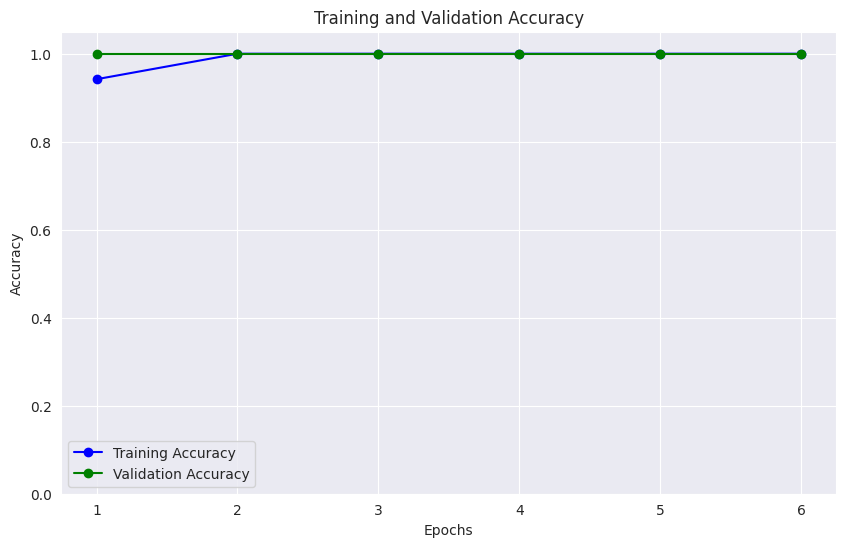

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Evaluating on test set...


Testing: |          | 0/? [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

    Non-Fire       1.00      1.00      1.00        24
        Fire       1.00      1.00      1.00        23

    accuracy                           1.00        47
   macro avg       1.00      1.00      1.00        47
weighted avg       1.00      1.00      1.00        47



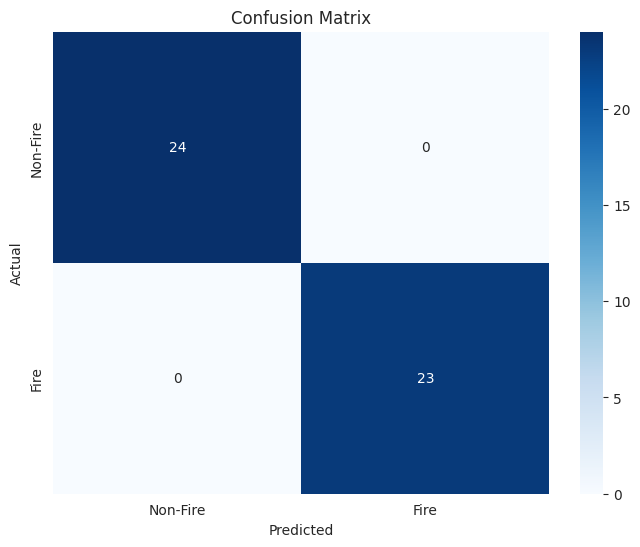

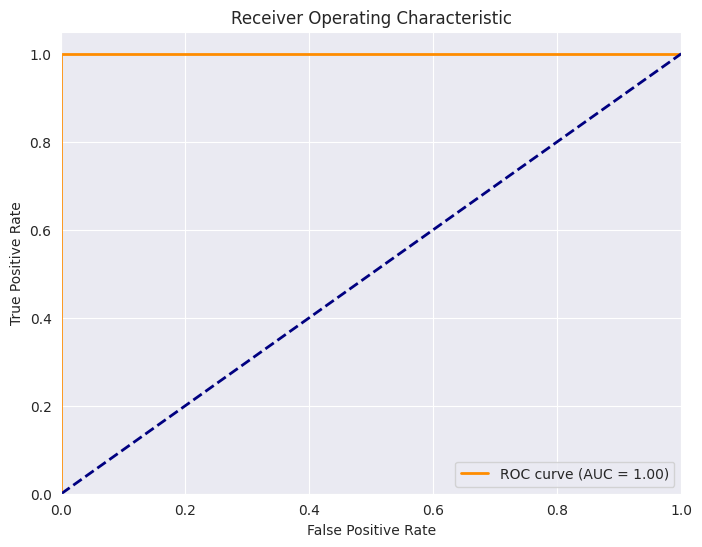

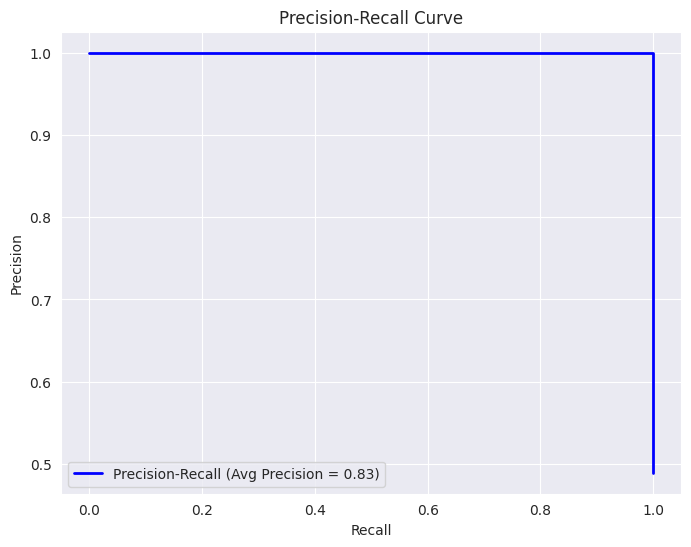

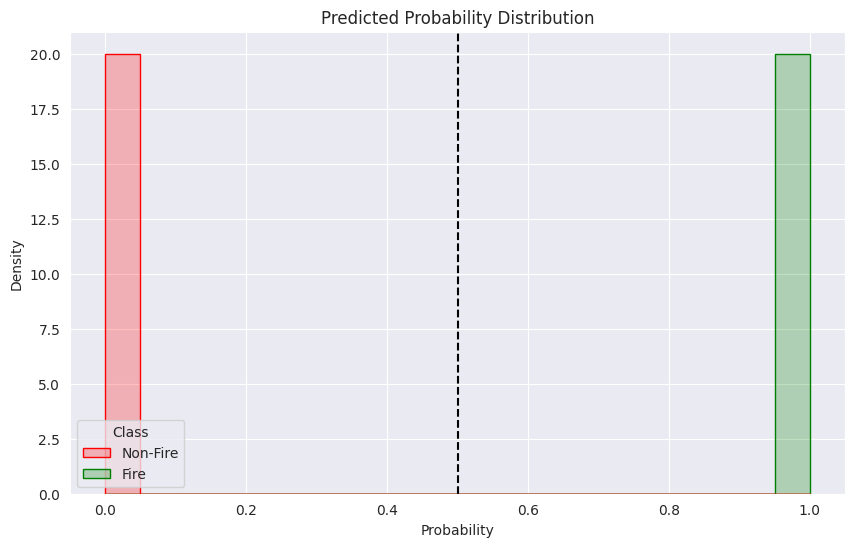

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            1.0            │
│          test_f1          │            1.0            │
│         test_loss         │  0.00010896103776758537   │
│      test_precision       │            1.0            │
│        test_recall        │            1.0            │
└───────────────────────────┴───────────────────────────┘

Fusion model weights saved
Fire predictor initialized and ready for deployment


In [77]:
# Initialize feature extractors (load with trained weights)
print("Loading pretrained feature extractors...")
# Load ViT extractor from Lightning checkpoint
vit_extractor = FireFeatureExtractorViT.load_from_checkpoint("Saved_Features/ViT_fire_feature_extractor.pth")

# Initialize CNN extractor and load weights
cnn_extractor = FireFeatureExtractorCNN()
cnn_extractor.load_state_dict(
    torch.load("Saved_Features/CNN_fire_feature_extractor.pth"),
    strict=False  # Ignore classifier weights
)

# Remove classifier from CNN model
cnn_extractor.classifier = nn.Identity()  # Replace classifier with identity function

# Set both models to evaluation mode
vit_extractor.eval()
cnn_extractor.eval()
print("Feature extractors loaded and ready")

# Fusion model configuration
config = {
    "lr": 5e-4,          # Learning rate
    "hidden_dim": 768,    # Hidden layer dimension
    "dropout_rate": 0.2,  # Dropout probability
    "pos_weight": 1.0     # Class imbalance weight
}

# Dataset paths
vit_fire_dir = "dataset/RGB/fire"
vit_non_fire_dir = "dataset/RGB/no_fire"
cnn_fire_dir = "dataset/thermal/fire"
cnn_non_fire_dir = "dataset/thermal/no_fire"

# Train fusion model
print("\nTraining fusion model...")
fusion_model, results = train_fusion_model(
    vit_extractor,
    cnn_extractor,
    vit_fire_dir,
    vit_non_fire_dir,
    cnn_fire_dir,
    cnn_non_fire_dir,
    max_epochs=20,
    config=config,
    visuals=True  # Enable advanced visualizations
)

# Save model weights
fusion_model.eval()
torch.save(fusion_model.state_dict(), "Saved_Features/fusion_model_weights.pth")
print("Fusion model weights saved")

# Initialize predictor for deployment
predictor = FirePredictor(fusion_model, vit_extractor, cnn_extractor)
print("Fire predictor initialized and ready for deployment")

In [78]:
# Example prediction using the trained fusion model
print("\nRunning example prediction...")
# Paths to test images
vit_path = "dataset/RGB/fire/00008.JPG"      # RGB image path
cnn_path = "dataset/thermal/fire/00008.JPG"  # Thermal image path

# Make prediction
prediction, probability = predictor.predict(vit_path, cnn_path)

# Display results
print("\nPredicting FIRE images:")
print(f"  RGB Image: {os.path.basename(vit_path)}")
print(f"  Thermal Image: {os.path.basename(cnn_path)}")
print(f"Prediction: {prediction} (Probability: {probability:.4f})")
print(f"Interpretation: {'FIRE DETECTED' if prediction == 'Fire' else 'No fire detected'}")

# Add visual confirmation if images exist
if os.path.exists(vit_path) and os.path.exists(cnn_path):
    print("\nImage verification:")
    print(f"  RGB image exists: {'✓' if os.path.exists(vit_path) else '✗'}")
    print(f"  Thermal image exists: {'✓' if os.path.exists(cnn_path) else '✗'}")
else:
    print("\nWarning: One or both test images not found")


Running example prediction...

Predicting FIRE images:
  RGB Image: 00008.JPG
  Thermal Image: 00008.JPG
Prediction: Fire (Probability: 1.0000)
Interpretation: FIRE DETECTED

Image verification:
  RGB image exists: ✓
  Thermal image exists: ✓


In [73]:
# Example prediction using the trained fusion model
print("\nRunning example prediction...")
# Paths to test images
vit_path = "dataset/RGB/no_fire/00052.JPG"      # RGB image path
cnn_path = "dataset/thermal/no_fire/00052.JPG"  # Thermal image path

# Make prediction
prediction, probability = predictor.predict(vit_path, cnn_path)

# Display results
print("\nPredicting NON-FIRE images:")
print(f"  RGB Image: {os.path.basename(vit_path)}")
print(f"  Thermal Image: {os.path.basename(cnn_path)}")
print(f"Prediction: {prediction} (Probability: {probability:.4f})")
print(f"Interpretation: {'FIRE DETECTED' if prediction == 'Fire' else 'No fire detected'}")

# Add visual confirmation if images exist
if os.path.exists(vit_path) and os.path.exists(cnn_path):
    print("\nImage verification:")
    print(f"  RGB image exists: {'✓' if os.path.exists(vit_path) else '✗'}")
    print(f"  Thermal image exists: {'✓' if os.path.exists(cnn_path) else '✗'}")
else:
    print("\nWarning: One or both test images not found")


Running example prediction...

Predicting NON-FIRE images:
  RGB Image: 00052.JPG
  Thermal Image: 00052.JPG
Prediction: Not Fire (Probability: 0.0002)
Interpretation: No fire detected

Image verification:
  RGB image exists: ✓
  Thermal image exists: ✓
